In [2]:
!pip install kaggle
import json
!mkdir .kaggle

#Enter your kaggle username and api token
!cp '/content/kaggle.json' ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}


In [4]:
!kaggle datasets list -s 'asl'

ref                                                          title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
grassknoted/asl-alphabet                                     ASL Alphabet                                        1GB  2018-04-22 19:31:36          14000  
danrasband/asl-alphabet-test                                 ASL Alphabet Test                                  24MB  2018-08-01 04:02:18           1311  
mrgeislinger/asl-rgb-depth-fingerspelling-spelling-it-out    ASL Fingerspelling Images (RGB & Depth)             2GB  2019-12-17 02:52:11            309  
lucasvieirademiranda/aslalphabet                             asl-alphabet                                        2GB  2018-11-23 17:36:46            127  
datamunge/sign-language-mnist                                Sign Lang

In [5]:
!kaggle datasets download -d grassknoted/asl-alphabet -p /content --force

 98% 1.01G/1.03G [00:12<00:00, 66.0MB/s]
100% 1.03G/1.03G [00:12<00:00, 87.9MB/s]


In [7]:
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_alphabet_t

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_size = (32, 32)
batch_size = 32

train_ds = image_dataset_from_directory(
    "/content/asl_alphabet_train/asl_alphabet_train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds =image_dataset_from_directory(
    "/content/asl_alphabet_train/asl_alphabet_train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


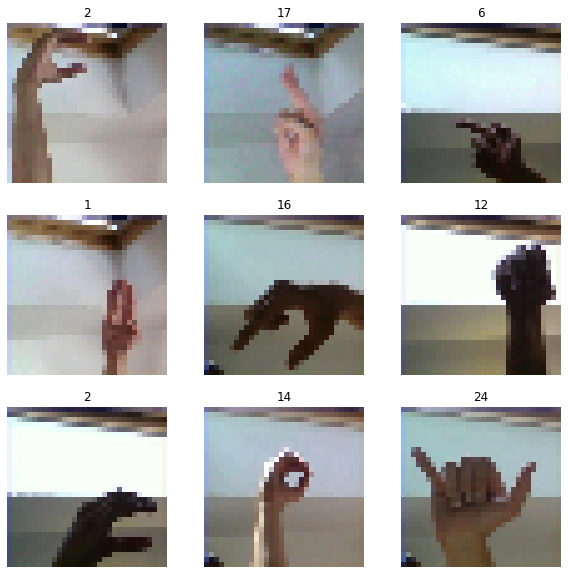

In [22]:
#visualizing the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


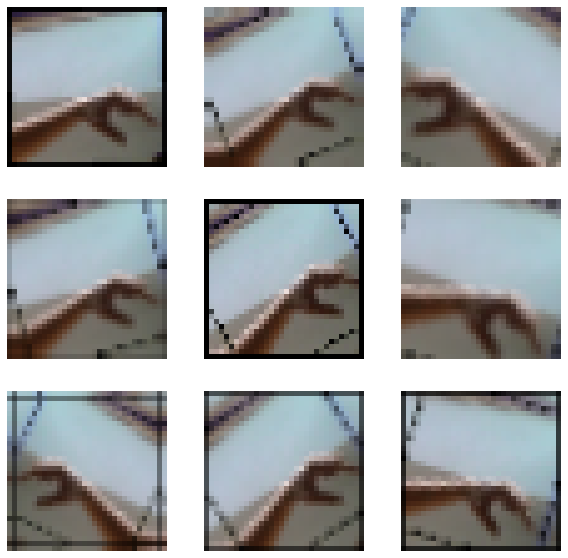

In [23]:
#Augmenting the images
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [33]:

INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)

vgg_layers.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [34]:
for layer in vgg_layers.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8ee1346a20> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ee1346c18> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ee1346e48> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8ee13535f8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ee1353d68> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ee13afc18> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8ee1358940> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ee12de198> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ee12def98> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ee12e7470> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8ee12e7c50> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8ee12f3

In [35]:
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(29, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 29)               

In [36]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., # rescaling
                                   rotation_range = 40,  # for augmentation
                                   width_shift_range = 0.2,
                                   validation_split = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory("/content/asl_alphabet_train/asl_alphabet_train",
                                                    batch_size = 32,
                                                    subset="training",
                                                    class_mode = 'binary', 
                                                    target_size = (32, 32))

test_generator = test_datagen.flow_from_directory("/content/asl_alphabet_train/asl_alphabet_train",
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (32, 32))

val_generator = val_datagen.flow_from_directory("/content/asl_alphabet_test/",
                                                subset = "validation",
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (32, 32))

Found 69600 images belonging to 29 classes.
Found 87000 images belonging to 29 classes.
Found 5 images belonging to 1 classes.


In [37]:
EPOCHS = 10
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_generator, validation_data = test_generator,
                    batch_size=32,
                    callbacks=[es_callback], 
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/10
  11/2175 [..............................] - ETA: 2:16:44 - loss: 3.4822 - accuracy: 0.0540

KeyboardInterrupt: ignored